In [1]:
import fly_plot_lib.plot as fpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import figurefirst as fifi
from scipy import stats
#import statsmodels.api as sm


2.2.4
recommended version: 1.1.1 or greater


# Some helper functions for plotting means and CI's for plots


In [2]:
#helper function for slicing means with standard errors
def slice_means_gs(df, index, time_key= "time stamp", start=-100, stop=3000):
    time_vec=[]
    mean_vec=[]
    upper_vec =[]
    lower_vec =[]
    df=df[df[time_key].between(start, stop)]
    for i in df[time_key].unique():
        dummy_df =df[df[time_key]==i]
        dummy_df=dummy_df[dummy_df['ground speed'].between(0, 2.0)]
        time_vec.append(i)
        mean = dummy_df[index].mean()
        upper= dummy_df[index].mean() + dummy_df[index].sem()*1.96
        lower= dummy_df[index].mean() - dummy_df[index].sem()*1.96
        mean_vec.append(mean)
        upper_vec.append(upper)
        lower_vec.append(lower)
    return time_vec, mean_vec, upper_vec, lower_vec

In [3]:
#helper function for slicing means with standard errors
def slice_head_prop(df, index='heading', time_key= "time stamp", start=-100, stop=3000):
    time_vec=[]
    uw_vec =[]
    cw_vec =[]
    dw_vec =[]
    df=df[df[time_key].between(start, stop)]
    for i in df[time_key].unique():
        dummy_df =df[df[time_key]==i]
        dummy_df=dummy_df[dummy_df['ground speed'].between(0, 2.0)]
        time_vec.append(i)
        tot =float(len(dummy_df))
        dummy_df['abs head'] =np.abs(dummy_df[index])
        #df[df < 2.0 ].count() 
        uw = dummy_df[dummy_df['abs head']<np.pi/4.].count()
        cw =dummy_df[dummy_df['abs head'].between(np.pi/4., 3.*np.pi/4)].count()
        dw =dummy_df[dummy_df['abs head']>3*np.pi/4.].count()
        uw_vec.append(uw/tot)
        cw_vec.append(cw/tot)
        dw_vec.append(dw/tot)
    return time_vec, uw_vec, cw_vec, dw_vec
    

In [4]:
def slice_means_time_lumping(df, index, time_key= "time stamp", start=-100, stop=3000, bin_size=10):
    time_vec=[]
    mean_vec=[]
    upper_vec =[]
    lower_vec =[]
    df=df[df[time_key].between(start, stop)]
    temporal_bins=np.arange(start, stop, bin_size)
    #print(temporal_bins)
    for i in temporal_bins:
        dummy_df =df[df[time_key].between(i-bin_size/2, i+bin_size/2)]
        time_vec.append(i)
        
        mean = dummy_df[index].mean()
        upper= dummy_df[index].mean() + dummy_df[index].sem()*1.96
        lower= dummy_df[index].mean() - dummy_df[index].sem()*1.96
        mean_vec.append(mean)
        upper_vec.append(upper)
        lower_vec.append(lower)
    return time_vec, mean_vec, upper_vec, lower_vec

In [5]:
def slice_props_time_lumping(df, index, time_key= "time stamp", start=-100, stop=3000, bin_size=10):
    time_vec=[]
    uw_vec =[]
    cw_vec =[]
    dw_vec =[]
    df=df[df[time_key].between(start, stop)]
    temporal_bins=np.arange(start, stop, bin_size)
    #print(temporal_bins)
    for i in temporal_bins:
        dummy_df =df[df[time_key].between(i-bin_size/2, i+bin_size/2)]
        time_vec.append(i)
        dummy_df['abs head'] =np.abs(dummy_df[index])
        tot =float(len(dummy_df))
        uw = dummy_df[dummy_df['abs head']<np.pi/4.]
        cw =dummy_df[dummy_df['abs head'].between(np.pi/4., 3.*np.pi/4)]
        dw =dummy_df[dummy_df['abs head']>3*np.pi/4.]
        uw_=float(len(uw))
        cw_=float(len(cw))
        dw_ =float(len(dw))
        uw_vec.append(uw_/tot)
        cw_vec.append(cw_/tot)
        dw_vec.append(dw_/tot)
    return time_vec, uw_vec, cw_vec, dw_vec

In [6]:
#Control data sets need to be trimmed for one second after pulse
def get_longer_traj(df, time_min = 1680, id_key='obj_id_unique'):
    catcher =[]
    for i in df[id_key].unique():
        d = df[df[id_key]==i]
        d = d[d['time stamp'].between(-100, 5000)]
        if d['time stamp'].max() >time_min:
            catcher.append(d)
    final_df =pd.concat(catcher)
    return final_df
        

In [7]:
#Ethanol helper functions from Floris Notebook
# Helper functions 

def wrap_angle(a):
    return np.arctan2(np.sin(a), np.cos(a))

def plot_wind_quivers(df, ax=None, res=3, wind_quiver_index=0, headwidth=7, alpha=0.5):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    i = int(res/2.)
    
    xrang = df['position_x'].max() - df['position_x'].min()
    yrang = df['position_y'].max() - df['position_y'].min()

    x = np.arange(df['position_x'].min()-0.2*xrang, df['position_x'].max()+0.2*xrang, .1)
    y = np.arange(df['position_y'].min()-0.2*yrang, df['position_y'].max()+0.2*yrang, .1)
    X, Y = np.meshgrid(x, y)
    
    wind_x = df.wind_speed.values[wind_quiver_index]*np.cos(df.wind_direction.values[wind_quiver_index])
    wind_y = df.wind_speed.values[wind_quiver_index]*np.sin(df.wind_direction.values[wind_quiver_index])
    
    V = wind_x.mean()*np.ones_like(X[i:-1:res, i:-1:res])
    U = wind_y.mean()*np.ones_like(Y[i:-1:res, i:-1:res])
    
    q = ax.quiver(X[i:-1:res, i:-1:res], Y[i:-1:res, i:-1:res], V, U, alpha=alpha, headwidth=headwidth)

def plot_trajec(df, ax=None, size_radius=5, nskip = 190, 
                show_wind_quivers=True, wind_quiver_index=0, 
                wind_quiver_res=3, wind_quiver_headwidth=7, 
                wind_quiver_alpha=0.5,
                color='time'):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    if show_wind_quivers:
        plot_wind_quivers(df, ax, wind_quiver_index=wind_quiver_index, res=wind_quiver_res, headwidth=wind_quiver_headwidth, alpha=wind_quiver_alpha)
    
    df['t'] = df['time_epoch'] - df['time_epoch'].values[0]
    
    if color == 'time':
        color = df['t'].values
        colormap='bone_r'
        colornorm=[0.05*df['t'].values[-1],df['t'].values[-1]]
        
    elif color == 'odor':
        color = copy.copy( df['odor'].values )
        colormap='hot'
        color[color>400] = 400 # clip
        colornorm=[0, 800]
        
    fpl.colorline_with_heading(ax, df['position_x'].values, df['position_y'].values, 
                                    color, wrap_angle( df['course'].values + np.pi), 
                                    nskip=nskip, size_radius=size_radius, deg=False, 
                                    colormap=colormap, center_point_size=0.0001,
                                    colornorm=colornorm, show_centers=False)

    ax.set_aspect('equal')
    xrang = df['position_x'].max() - df['position_x'].min()
    yrang = df['position_y'].max() - df['position_y'].min()
    ax.set_xlim(df['position_x'].min()-0.1*xrang, df['position_x'].max()+0.1*xrang)
    ax.set_ylim(df['position_y'].min()-0.1*yrang, df['position_y'].max()+0.1*yrang)

    fifi.mpl_functions.adjust_spines(ax, [])

    

def mean_angle(angle):
    return np.arctan2(np.nanmean(np.sin(angle)), np.nanmean(np.cos(angle)))
    
def std_angle(angle):
    return np.sqrt( np.sum(wrap_angle(angle - mean_angle(angle))**2) / len(angle) )

def unwrap_angle(z, correction_window_for_2pi=100, n_range=2, plot=False):
    smooth_zs = np.array(z[0:2])
    for i in range(2, len(z)):
        first_ix = np.max([0, i-correction_window_for_2pi])
        last_ix = i

        nbase = np.round( (smooth_zs[-1] - z[i])/(2*np.pi) )

        candidates = []
        for n in range(-1*n_range, n_range):
            candidates.append(n*2*np.pi+nbase*2*np.pi+z[i])
        error = np.abs(candidates - np.mean(smooth_zs[first_ix:last_ix])) 
        smooth_zs = np.hstack(( smooth_zs, [candidates[np.argmin(error)]] ))
    if plot:
        plt.plot(smooth_zs, '.', color='black', markersize=1)
        
    return smooth_zs


def diff_angle(angles, dt, params, 
               derivative_method='smooth_finite_difference.butterdiff', 
               correction_window_for_2pi=100):
    '''
    Take a filtered derivative of an angle
    '''
    
    family, method = derivative_method.split('.')

    '''
    angles = interpolate_outliers_angle(angles, outlier_window_size, outlier_stride, outlier_max_std)
    diff_angles = np.diff(angles)
    diff_angles = np.hstack((0, diff_angles, 0))
    wrapped_diff_angle = wrap_angle(diff_angles)
    unwrapped_angle = scipy.integrate.cumtrapz(wrapped_diff_angle)
    
    corrected_unwrapped_angle = [unwrapped_angle[0], unwrapped_angle[1]]
    for i in range(2, len(unwrapped_angle)):
        first_ix = np.max([0, i-correction_window_for_2pi])
        last_ix = i
        error = (unwrapped_angle[i] - mean_angle(corrected_unwrapped_angle[first_ix:last_ix])) / (2*np.pi)
        npi = np.round(error)
        corrected_unwrapped_angle.append(unwrapped_angle[i] - npi*2*np.pi)
    
    offset = mean_angle(angles) - mean_angle(unwrapped_angle)
    unwrapped_angle += offset
    '''
    
    unwrapped_angle = unwrap_angle(angles, correction_window_for_2pi=correction_window_for_2pi, n_range=5)

    angles_smooth, angles_dot = pynumdiff.__dict__[family].__dict__[method](unwrapped_angle, dt, params, {})
    return wrap_angle(angles_smooth), angles_dot

def get_pandas_dataframe_for_trajec(trajec, wind_speed, kalmanize_phi=False):
    tdf = DataFrame({'position_x': trajec.positions[:,0],
                 'position_y': trajec.positions[:,1],
                 'position_z': trajec.positions[:,2],
                 'velocity_x': trajec.velocities[:,0],
                 'velocity_y': trajec.velocities[:,1],
                 'velocity_z': trajec.velocities[:,2],
                 'frames': np.arange(trajec.first_frame, trajec.first_frame+trajec.length),
                 'time_epoch': trajec.timestamp_epoch + trajec.time_fly ,
                 'objid': [trajec.key for i in range(trajec.length)],
                 'speed': trajec.speed,
                 'course': np.arctan2(trajec.velocities[:,1], trajec.velocities[:,0]),
                 'odor': trajec.odor,
                 'odor_stimulus': [trajec.odor_stimulus for i in range(trajec.length)],
                 'wind_speed': wind_speed*np.ones_like(trajec.odor),
                 'wind_direction': -np.pi*np.ones_like(trajec.odor), 
    })
    
    xvel = tdf.velocity_x
    yvel = tdf.velocity_y
    w = tdf.wind_speed 
    zeta = tdf.wind_direction
    dt = np.mean(np.diff(tdf.time_epoch))
    
    air_x = xvel - w*np.cos(zeta)
    air_y = yvel - w*np.sin(zeta)

    

    #phi, _ = pynumdiff.smooth_finite_difference.gaussiandiff(phi, dt, [50])

    #########################
    '''
    x = air_x
    params = [1, 0.1]
    r, q = params
    A = np.matrix([[1, dt], [0, 1]])
    B = np.matrix([[0], [0]])
    C = np.matrix([[1, 0]])
    R = np.matrix([[r]])
    Q = np.matrix([[1e-16, 0], [0, q]])
    x0 = np.matrix([[x[0]], [0]])
    P0 = np.matrix(100*np.eye(2))
    y = np.matrix(x)
    u = None
    xhat_fp, xhat_fm, P_fp, P_fm = pynumdiff.kalman_smooth.__kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)
    air_x = np.ravel(xhat_fp[0,:])

    x = air_y
    params = [1, 0.1]
    r, q = params
    A = np.matrix([[1, dt], [0, 1]])
    B = np.matrix([[0], [0]])
    C = np.matrix([[1, 0]])
    R = np.matrix([[r]])
    Q = np.matrix([[1e-16, 0], [0, q]])
    x0 = np.matrix([[x[0]], [0]])
    P0 = np.matrix(100*np.eye(2))
    y = np.matrix(x)
    u = None
    xhat_fp, xhat_fm, P_fp, P_fm = pynumdiff.kalman_smooth.__kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)
    air_y = np.ravel(xhat_fp[0,:])
    '''
    
    
    phi = np.arctan2(air_y, air_x)
    
    if kalmanize_phi:
        phi = flymath.remove_angular_rollover(phi, np.pi*0.5)

        x = phi
        params = [1, 0.1]
        r, q = params
        A = np.matrix([[1, dt], [0, 1]])
        B = np.matrix([[0], [0]])
        C = np.matrix([[1, 0]])
        R = np.matrix([[r]])
        Q = np.matrix([[1e-16, 0], [0, q]])
        x0 = np.matrix([[x[0]], [0]])
        P0 = np.matrix(100*np.eye(2))
        y = np.matrix(x)
        u = None
        xhat_fp, xhat_fm, P_fp, P_fm = pynumdiff.kalman_smooth.__kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)
        phi = np.ravel(xhat_fp[0,:])
    
    
    tdf['body_orientation'] = phi #th.fix_angular_rollover(phi)
    
    return tdf

# Load in all data sets

In [10]:
#Extra controls
#orco>csChrimson flies with no extra ATR in diet
noatr=pd.read_csv('../trimmed_data/supp/OrcoCsChrimson_no_atr.csv')
#csChrimsons heterozygotes- for heterozygous White control
u1wt=pd.read_csv('../trimmed_data/supp/CsChrimson_hets.csv')
#Data in main fig added here for easier comparison
#WT control
wt=pd.read_csv('../trimmed_data/main/wild_type_laminar_merged.csv')
#Main trimmed orco>csChrimson data set
orco=pd.read_csv('../trimmed_data/main/OrcoCsChrimson_laminar_wind_merged.csv')
#Floris 2014, data set
etoh=pd.read_hdf('../trimmed_data/supp/fly_trajec_data_all_etoh.hdf')
no_odor=pd.read_hdf('../trimmed_data/supp/fly_trajec_data_noodor_all.hdf')

In [10]:
#Ground Speed Calculation
noatr['ground speed']= (noatr['xvel']**2+noatr['yvel']**2)**0.5
u1wt['ground speed']= (u1wt['xvel']**2+u1wt['yvel']**2)**0.5
wt['ground speed']=(wt['xvel']**2+wt['yvel']**2)**0.5
orco['ground speed']=(orco['xvel']**2+orco['yvel']**2)**0.5
#etoh set is old and has slightly different key names
etoh['ground speed']=(etoh['velocity_y']**2+etoh['velocity_x']**2)**0.5
no_odor['ground speed']=(no_odor['velocity_y']**2+no_odor['velocity_x']**2)**0.5

In [12]:
#Control data sets need to be trimmed for one second after pulse condition
noatr =get_longer_traj(noatr)
u1wt=get_longer_traj(u1wt)

In [14]:
#split all data into flash and sham sets
orco100=orco[orco['duration']==100]
orco0 =orco[orco['duration']==0]
noatr100=noatr[noatr['duration']==100]
noatr0=noatr[noatr['duration']==0]
u1wt100=u1wt[u1wt['duration']==100]
u1wt0=u1wt[u1wt['duration']==0]
wt100=wt[wt['duration']==100]
wt0=wt[wt['duration']==0]


In [17]:
#Standardize a couple size things so figures all plots come out the same
ms=4
lw=.5
fs=6
linew=.5
tl=3

In [18]:
#old data plots z position from -,25 to ,25 so just correcting to have easier dimmensions
etoh['z'] =etoh['position_z']+.25
no_odor['z'] =no_odor['position_z']+.25

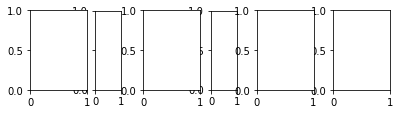

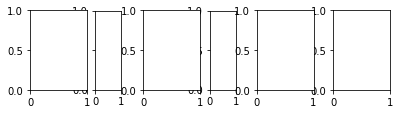

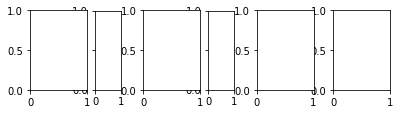

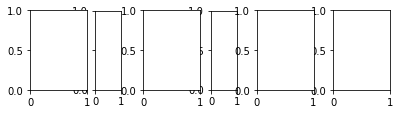

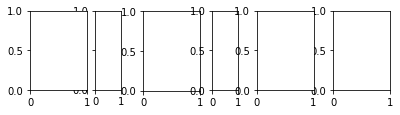

In [9]:
#Fifi template intialization
template = '../figure_first_templates/genetic_control_supplement.svg'
layout = fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])

# Orco Gal4 >CsChrimson Plots

In [21]:
ax=layout.axes[('orco', 'hm_f')]

In [22]:
cmap_reversed = plt.cm.get_cmap('bone_r')
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(orco100['time stamp'], orco100['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [23]:
ax =layout.axes[('orco', 'prop_f')]

In [24]:
#Grab population mean and error boundaries for both flash and sham subsets for orco flies for altitude
t, uw, cw, dw= slice_head_prop(orco100)
#give unique name to these variables because takes a while to crunch

In [25]:
ax.plot(uw, t, color = 'green', linewidth =.5)
ax.plot(cw, t, color ='blue', linewidth=.5)
ax.plot(dw, t, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


In [26]:
ax=layout.axes[('orco', 'hm_s')]

In [27]:
cmap_reversed = plt.cm.get_cmap('bone_r')

ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(orco0['time stamp'], orco0['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [28]:
ax =layout.axes[('orco', 'prop_s')]

In [29]:
t0, uw0, cw0, dw0= slice_head_prop(orco0)

In [30]:
ax.plot(uw0, t0, color = 'green', linewidth =.5)
ax.plot(cw0, t0, color ='blue', linewidth=.5)
ax.plot(dw0, t0, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
#ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


In [31]:
ax=layout.axes[('orco', 'gs')]

In [32]:
#Grab population mean and error boundaries for both flash and sham subsets for orco flies
t, m, u, l= slice_means_gs(orco100, 'ground speed')
t0, m0, u0, l0=slice_means_gs(orco0, 'ground speed')

In [33]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .6], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


In [34]:
ax=layout.axes[('orco', 'alt')]

In [35]:
#Grab population mean and error boundaries for both flash and sham subsets for orco flies for altitude
t, m, u, l= slice_means_gs(orco100, 'z')
t0, m0, u0, l0=slice_means_gs(orco0, 'z')

In [36]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)
#ax.set_ylabel("Ground Speed (m/s)")
ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .5], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


# Orco>CsChrimso, without ATR Plots


In [38]:
ax=layout.axes[('no_atr', 'hm_f')]

In [39]:
cmap_reversed = plt.cm.get_cmap('bone_r')
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(noatr100['time stamp'], noatr100['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [40]:
ax=layout.axes[('no_atr', 'prop_f')]

In [41]:
noatr_t100, noatr_uw100, noatr_cw100, noatr_dw100= slice_head_prop(noatr100)

ax.plot(noatr_uw100, noatr_t100, color = 'green', linewidth =.5)
ax.plot(noatr_cw100, noatr_t100, color ='blue', linewidth=.5)
ax.plot(noatr_dw100, noatr_t100, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [42]:
ax=layout.axes[('no_atr', 'hm_s')]

In [43]:
cmap_reversed = plt.cm.get_cmap('bone_r')

ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(noatr0['time stamp'], noatr0['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [44]:
ax=layout.axes[('no_atr', 'prop_s')]

In [45]:
noatr_t0, noatr_uw0, noatr_cw0, noatr_dw0= slice_head_prop(noatr0)

ax.plot(noatr_uw0, noatr_t0, color = 'green', linewidth =.5)
ax.plot(noatr_cw0, noatr_t0, color ='blue', linewidth=.5)
ax.plot(noatr_dw0, noatr_t0, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
#ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [46]:
ax=layout.axes[('no_atr', 'gs')]

In [47]:
#Grab population mean and error boundaries for both flash and sham subsets for the noatr orco flies
t, m, u, l= slice_means_gs(noatr100, 'ground speed')
t0, m0, u0, l0=slice_means_gs(noatr0, 'ground speed')

In [48]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .6], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [49]:
ax=layout.axes[('no_atr', 'alt')]

In [50]:
t, m, u, l= slice_means_gs(noatr100, 'z')
t0, m0, u0, l0=slice_means_gs(noatr0, 'z')

In [51]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)
#ax.set_ylabel("Ground Speed (m/s)")
ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .5], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# Wild Type Controls, Same as Figure 1

In [52]:
ax=layout.axes[('wt', 'hm_f')]

In [53]:
cmap_reversed = plt.cm.get_cmap('bone_r')
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(wt100['time stamp'], wt100['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [54]:
ax=layout.axes[('wt', 'prop_f')]

In [55]:
wt_t100, wt_uw100, wt_cw100, wt_dw100= slice_head_prop(wt100)

ax.plot(wt_uw100, wt_t100, color = 'green', linewidth =.5)
ax.plot(wt_cw100, wt_t100, color ='blue', linewidth=.5)
ax.plot(wt_dw100, wt_t100, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [56]:
ax=layout.axes[('wt', 'hm_s')]

In [57]:
cmap_reversed = plt.cm.get_cmap('bone_r')

ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(wt0['time stamp'], wt0['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [58]:
ax=layout.axes[('wt', 'prop_s')]

In [59]:
wt_t0, wt_uw0, wt_cw0, wt_dw0= slice_head_prop(wt0)

ax.plot(wt_uw0,wt_t0, color = 'green', linewidth =.5)
ax.plot(wt_cw0, wt_t0, color ='blue', linewidth=.5)
ax.plot(wt_dw0, wt_t0, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
#ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [60]:
ax=layout.axes[('wt', 'gs')]

In [61]:
#Grab population mean and error boundaries for both flash and sham subsets of wt flies
t, m, u, l= slice_means_gs(wt100, 'ground speed')
t0, m0, u0, l0=slice_means_gs(wt0, 'ground speed')

In [62]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .6], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [63]:
ax=layout.axes[('wt', 'alt')]

In [64]:
#Grab population mean and error boundaries for both flash and sham subsets of wt flies
t, m, u, l= slice_means_gs(wt100, 'z')
t0, m0, u0, l0=slice_means_gs(wt0, 'z')

In [65]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)
#ax.set_ylabel("Ground Speed (m/s)")
ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .5], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# CsChrimson Heterozygotes

In [66]:
ax=layout.axes[('u1wt', 'hm_f')]

In [67]:
cmap_reversed = plt.cm.get_cmap('bone_r')
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(u1wt100['time stamp'], u1wt100['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([r'-$\pi$', r'-$\pi/2$', '0',r'$\pi/2$', r'$\pi$' ])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [68]:
ax=layout.axes[('u1wt', 'prop_f')]

In [69]:
u1wt_t100, u1wt_uw100, u1wt_cw100, u1wt_dw100= slice_head_prop(u1wt100)

ax.plot(u1wt_uw100,u1wt_t100, color = 'green', linewidth =.5)
ax.plot(u1wt_cw100, u1wt_t100, color ='blue', linewidth=.5)
ax.plot(u1wt_dw100, u1wt_t100, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [70]:
ax=layout.axes[('u1wt', 'hm_s')]

In [71]:
cmap_reversed = plt.cm.get_cmap('bone_r')

ax.set_xlim(-3.2, 3.2)
a = np.arange(-100,3000,10)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-100,3010, 10)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(u1wt0['time stamp'], u1wt0['heading'],  bins =(x, y))

newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
sumz = newdf.sum(axis=0)

newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, 675, 3000],  tick_length=3, linewidth=.5)
fifi.mpl_functions.set_fontsize(ax, fs)


In [72]:
ax=layout.axes[('u1wt', 'prop_s')]

In [73]:
u1wt_t0, u1wt_uw0, u1wt_cw0, u1wt_dw0= slice_head_prop(u1wt0)

ax.plot(u1wt_uw0,u1wt_t0, color = 'green', linewidth =.5)
ax.plot(u1wt_cw0, u1wt_t0, color ='blue', linewidth=.5)
ax.plot(u1wt_dw0, u1wt_t0, color = 'orange', linewidth =.5)
ax.set_ylim(-100, 3000)
#ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [74]:
ax=layout.axes[('u1wt', 'gs')]

In [75]:
#Grab population mean and error boundaries for both flash and sham subsets of csChrimson hets (u1 is an itnernal lab name for bloomington 55135)
t, m, u, l= slice_means_gs(u1wt100, 'ground speed')
t0, m0, u0, l0=slice_means_gs(u1wt0, 'ground speed')

In [76]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .6], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [77]:
ax=layout.axes[('u1wt', 'alt')]

In [78]:
t, m, u, l= slice_means_gs(u1wt100, 'z')
t0, m0, u0, l0=slice_means_gs(u1wt0, 'z')

In [79]:
ax.plot(m, t, color = 'red', label = 'Orco>csChrimson', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'Control', linewidth=.5)
#ax.set_ylabel("Ground Speed (m/s)")
ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t, u, l, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.set_ylim(-100, 3000)
ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels(['','', ''])
ax.set_xticklabels([ '', '', ''])
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, .5], yticks=[0, 675, 3000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# Ethanol Course Direction Heat Map Comparison from van Breugel 2014, plotted in same format

In [80]:
ax=layout.axes[('etoh', 'hm_etoh')]

In [81]:
cmap_reversed = plt.cm.get_cmap('bone_r')

#ax.axhspan(0, .675, color = 'red', alpha = 0.2)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-.100,3.000,.05)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-.100,3.010, .05)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(etoh['time_since_odor_onset'], wrap_angle(etoh.course+np.pi),  bins =(x, y))
#print(bin_values)
newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
#print(newdf)
sumz = newdf.sum(axis=0)
#print(sumz)
newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0.002, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)


ax.set_xticklabels([])
ax.set_yticklabels([])

fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, .675, 3.000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# Clean Course Direction Heat Map Comparison from van Breugel 2014, plotted in same format

In [82]:
ax=layout.axes[('etoh', 'ca', 'hm_ca')]

In [83]:
cmap_reversed = plt.cm.get_cmap('bone_r')

#ax.axhspan(0, .675, color = 'red', alpha = 0.2)
ax.set_xlim(-3.2, 3.2)
a = np.arange(-.100,3.000,.05)
b = np.linspace(-np.pi, np.pi, 180)
x = np.arange(-.100,3.010, .05)
y = np.linspace(-np.pi, np.pi, 181)
bin_values,_,__ = np.histogram2d(no_odor['time_since_odor_onset'], wrap_angle(no_odor.course+np.pi),  bins =(x, y))
#print(bin_values)
newdf = pd.DataFrame(bin_values.T, columns=a, index=b)
#print(newdf)
sumz = newdf.sum(axis=0)
#print(sumz)
newdf_normed= newdf
for i in range(0,len(sumz)):
    newdf_normed.iloc[:,i] = newdf.iloc[:,i]/sumz.iloc[i]
X,Y = np.meshgrid(x,y)
# Plot the heatmap
ax.pcolormesh(Y, X, newdf_normed, vmin=0.002, vmax=0.04, cmap='bone_r', shading='flat', rasterized=True)

#ax.set_ylabel("Time (ms)")
ax.set_xticklabels([])
ax.set_yticklabels([])
#ax.set_xlabel("Heading")
#ax.set_title("Orco>csChrimson")
#ax.hist2d(orco100['heading'],(orco100['time stamp']), cmap = cmap_reversed, bins =(180, 310), vmin =0, vmax =15)
fifi.mpl_functions.adjust_spines(ax, ['left','bottom'], xticks =[-3.14, -3.14/2, 0, 3.14/2, 3.14], yticks=[0, .675, 3.000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# Ethanol Ground Speed

In [85]:
ax=layout.axes[('etoh', 'gs_etoh')]

In [86]:
t_, m_, u_, l_= slice_means_time_lumping(etoh, 'ground speed' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)
t0, m0, u0, l0=slice_means_time_lumping(etoh, 'ground speed' , time_key="time_before_odor_onset", start = -.5, stop = 0, bin_size=.01)

In [87]:
ax.plot(m_, t_, color = 'red', label = 'Light Pulse', linewidth =.5)
ax.plot(m0, t0, color ='red', label = 'No Pulse', linewidth=.5)
#ax.set_ylabel("Ground Speed (m/s)")
ax.fill_betweenx(t0, u0, l0, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t_, u_, l_, color = 'red', alpha = 0.2, label = '', linewidth =0)
#ax.legend()
#ax.set_xlabel("Time Relative to Trigger (ms)")
#ax.set_ylabel("Ground Speed (m/s)")
#ax.set_title("EtOH")
#ax.set_xlabel("Time Relative to Plume Entry")
#ax.axvspan(0, .675, color = 'red', alpha = 0.1)
ax.set_xlim(0, .6)
ax.set_ylim(-.1, 3)
ax.set_xticklabels([])
ax.set_yticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['bottom', 'left'],yticks=[0, .675, 3.000], xticks=[0, .6], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


# Clean Air ground speed

In [88]:
t_, m_, u_, l_= slice_means_time_lumping(no_odor, 'ground speed' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)
t0, m0, u0, l0=slice_means_time_lumping(no_odor, 'ground speed' , time_key="time_before_odor_onset", start = -.5, stop = 0, bin_size=.01)

In [89]:
ax.plot(m_, t_, color = 'k', label = 'Light Pulse', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'No Pulse', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t_, u_, l_, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.set_xlim(0, .6)
ax.set_ylim(-.100, 3.000)
ax.set_xticklabels([])
ax.set_yticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['bottom', 'left'],yticks=[0, .675, 3.000], xticks=[0, .6], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


# Ethanol and clean air altitude plots

In [90]:
ax=layout.axes[('etoh', 'alt_etoh')]

In [91]:
t_, m_, u_, l_= slice_means_time_lumping(etoh, 'z' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)
t0, m0, u0, l0=slice_means_time_lumping(etoh, 'z' , time_key="time_before_odor_onset", start = -.5, stop = 0, bin_size=.01)

In [92]:
ax.plot(m_, t_, color = 'red', label = 'Light Pulse', linewidth =.5)
ax.plot(m0, t0, color ='red', label = 'No Pulse', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'red', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t_, u_, l_, color = 'red', alpha = 0.2, label = '', linewidth =0)

ax.set_xlim(0, .5)
ax.set_ylim(-.1, 3)
ax.set_xticklabels([])
ax.set_yticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['bottom', 'left'],yticks=[0, .675, 3.000], xticks=[0, .5], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


In [93]:
t_, m_, u_, l_= slice_means_time_lumping(no_odor, 'z' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)
t0, m0, u0, l0=slice_means_time_lumping(no_odor, 'z' , time_key="time_before_odor_onset", start = -.5, stop = 0, bin_size=.01)

In [94]:
ax.plot(m_, t_, color = 'k', label = 'Light Pulse', linewidth =.5)
ax.plot(m0, t0, color ='k', label = 'No Pulse', linewidth=.5)

ax.fill_betweenx(t0, u0, l0, color = 'k', alpha = 0.2, label = '', linewidth =0)
ax.fill_betweenx(t_, u_, l_, color = 'k', alpha = 0.2, label = '', linewidth =0)

ax.set_xlim(0, .5)
ax.set_ylim(-.1, 3)
ax.set_xticklabels([])
ax.set_yticklabels([])
fifi.mpl_functions.adjust_spines(ax, ['bottom', 'left'],yticks=[0, .675, 3.000], xticks=[0, .5], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)


In [95]:
ax=layout.axes[('etoh', 'prop_etoh')]

In [96]:
et_t,et_u, et_c, et_d=slice_props_time_lumping(etoh, 'course' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)

/home/flybot/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [97]:
#Upwind and Downwind are flipped in floris's data so green and orange traces are swapped here
ax.plot(et_u,et_t, color = 'orange', linewidth =.5)
ax.plot(et_c, et_t, color ='blue', linewidth=.5)
ax.plot(et_d, et_t, color = 'green', linewidth =.5)
ax.set_ylim(-.100, 3.000)
#ax.axhspan(0, 675, color = 'red', alpha = 0.1)
ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, .675, 3.000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

In [98]:
ax=layout.axes[('etoh', 'ca', 'prop_ca')]

In [99]:
ca_t,ca_u, ca_c, ca_d=slice_props_time_lumping(no_odor, 'course' , time_key="time_since_odor_onset", start = 0.0, stop = 3.0, bin_size=.01)

/home/flybot/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [100]:
ax.plot(ca_u,ca_t, color = 'orange', linewidth =.5)
ax.plot(ca_c, ca_t, color ='blue', linewidth=.5)
ax.plot(ca_d, ca_t, color = 'green', linewidth =.5)
ax.set_ylim(-.100, 3.000)

ax.set_yticklabels([' ',' ', ' '])
ax.set_xticklabels([' ',' '])
fifi.mpl_functions.adjust_spines(ax, ['bottom'],xticks=[0, 1.0], yticks=[0, .675, 3.000], tick_length=3, linewidth=lw)
fifi.mpl_functions.set_fontsize(ax, fs)

# Figure first throw plots onto inkscape scg

In [101]:
layout.append_figure_to_layer(layout.figures['orco'], 'orco', cleartarget=True)
layout.append_figure_to_layer(layout.figures['no_atr'], 'no_atr', cleartarget=True)
layout.append_figure_to_layer(layout.figures['wt'], 'wt', cleartarget=True)
layout.append_figure_to_layer(layout.figures['u1wt'], 'u1wt', cleartarget=True)
layout.append_figure_to_layer(layout.figures['etoh'], 'etoh', cleartarget=True)

# Save svg


In [102]:
layout.write_svg(template)